### Sampled error analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pickle
from typing import Callable, Optional

# Add workspace to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Force imported libraries and modules to auto-reload
%load_ext autoreload
%autoreload 2

from tools import tensor_distance, create_subplots

from seemps.state import MPS, DEFAULT_STRATEGY
from seemps.analysis.mesh import Mesh, RegularInterval, mps_to_mesh_matrix
from seemps.analysis.factories import mps_tensor_product
from seemps.analysis.sampling import evaluate_mps, random_mps_indices
from seemps.analysis.chebyshev import cheb2mps, interpolation_coefficients
import seemps.tools
seemps.tools.DEBUG = 0

DATA_PATH = "data/"
SHOW_FIGURES = True

In [3]:
# fmt: off
from tools import set_plot_parameters
set_plot_parameters()

# Styles
LINESTYLE_1 = "solid"
LINESTYLE_2 = (0, (5, 1))

In [4]:
# Define configurations, colors and number of samples
configurations_norm_inf = [(1, 24), (2, 12), (3, 8), (4, 6), (6, 4)]
configurations_norm_2 = [(5, 20), (6, 20), (7, 20), (8, 20), (9, 20), (10, 20)]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
num_samples = [1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6]

# Define univariate and multivariate functions (product gaussian distribution)
σ = 1 / 3
func_1d = lambda x: (1 / (σ * np.sqrt(2 * np.pi))) * np.exp(-((x / (2 * σ)) ** 2))
func_tensor = lambda tensor: func_1d(np.sum(tensor**2, axis=-1))

# Define tolerance for the errors
tolerance = 1e-8

### Benchmark of the sampling error in norm-$\infty$.

In [5]:
def full_error(func_tensor: Callable, m: int, n: int, t: float):
    """
    Computes the full-tensor error between the discretization tensor of a function and its
    MPS/QTT representation using the Schmidt decomposition.
    """
    interval = RegularInterval(-1, 1, 2**n)
    mesh = Mesh([interval] * m)
    y_tensor = func_tensor(mesh.to_tensor())
    strategy = DEFAULT_STRATEGY.replace(tolerance=t, simplification_tolerance=t)
    mps = MPS.from_tensor(
        y_tensor.reshape([2] * (m * n)), strategy=strategy, normalize=False
    )
    error = tensor_distance(y_tensor.reshape(-1), mps.to_vector())
    return error, mps


def sampled_error(
    func_tensor: Callable,
    m: int,
    n: int,
    mps_md: MPS,
    sampled_points: np.ndarray,
    previous_points: Optional[np.ndarray] = None,
    num_iterations: int = 100,
):
    """
    Computes the sampled error between the a sampled subtensor tensor of a function and its
    MPS/QTT representation using the Schmidt decomposition. It runs num_iterations times
    to compute the mean and standard deviation.
    """
    interval = RegularInterval(-1, 1, 2**n)
    mesh = Mesh([interval] * m)

    errors = []
    for _ in range(num_iterations):
        # Compute sampled points and append them to previous points if given.
        num_previous_points = len(previous_points) if previous_points is not None else 0
        num_new_points = sampled_points - num_previous_points
        new_indices = random_mps_indices(mps_md, num_indices=num_new_points)
        if previous_points is not None and num_previous_points > 0:
            all_indices = np.concatenate((previous_points, new_indices))
        else:
            all_indices = new_indices

        # Compute sampled error in norm-infty.
        y_mps = evaluate_mps(mps_md, all_indices)
        M = mps_to_mesh_matrix([n] * m, mps_order="A")
        mesh_coordinates = mesh[all_indices @ M]
        y_vec = func_tensor(mesh_coordinates)
        sampled_error = tensor_distance(y_vec, y_mps)
        errors.append(sampled_error)

    return np.mean(errors), np.std(errors), all_indices

In [6]:
filename = "sampling_errors_infty.pkl"
if os.path.exists(DATA_PATH + filename):
    print(f"Loading {filename}.")
    with open(DATA_PATH + filename, "rb") as f:
        (list_benchmark_errors_inf, list_mean_errors_inf, list_std_errors_inf) = (
            pickle.load(f)
        )
else:
    print(f"Computing {filename}.")
    list_benchmark_errors_inf = []
    list_mean_errors_inf = []
    list_std_errors_inf = []
    for idx, config in enumerate(configurations_norm_inf):
        print(f"Configuration {idx+1}: {config}")
        m, n = config[0], config[1]
        exact_error, mps = full_error(func_tensor, m, n, tolerance)
        list_benchmark_errors_inf.append(exact_error)
        mean_errors = []
        std_errors = []
        previous_points = None
        for p in num_samples:
            print(f"Sampled points: {p}")
            mean_error, std_error, previous_points = sampled_error(
                func_tensor, m, n, mps, int(p), previous_points, 100
            )
            mean_errors.append(mean_error)
            std_errors.append(std_error)
        list_mean_errors_inf.append(np.array(mean_errors))
        list_std_errors_inf.append(np.array(std_errors))

    list_benchmark_errors_inf = np.array(list_benchmark_errors_inf)
    list_mean_errors_inf = np.array(list_mean_errors_inf)
    list_std_errors_inf = np.array(list_std_errors_inf)

    with open(DATA_PATH + filename, "wb") as f:
        data = (list_benchmark_errors_inf, list_mean_errors_inf, list_std_errors_inf)
        pickle.dump(data, f)

Loading sampling_errors_infty.pkl.


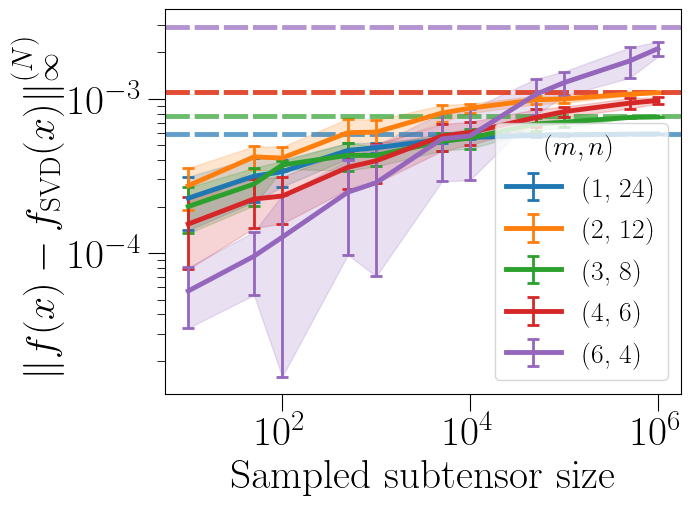

In [7]:
# fmt: off
def plot_error_inf(ax):
	for idx, config in enumerate(configurations_norm_inf):
		x = num_samples
		y = list_mean_errors_inf[idx]
		y_err = list_std_errors_inf[idx]
		y_exact = list_benchmark_errors_inf[idx]
		ax.axhline(y_exact, linestyle=LINESTYLE_2, alpha=0.7, color=colors[idx])
		ax.errorbar(x, y, y_err, linestyle=LINESTYLE_1, label=config, color=colors[idx], elinewidth=2, capsize=4, capthick=2)
		ax.fill_between(x, y - y_err, y + y_err, color=colors[idx], alpha=0.2)
	ax.set_xscale("log")
	ax.set_yscale("log")
	ax.legend(title=r"$(m, n)$", loc="lower right", fontsize=20, title_fontsize=20)

if SHOW_FIGURES:
	fig, ax = create_subplots()
	plot_error_inf(ax)
	ax.set_xlabel("Sampled subtensor size")
	ax.set_ylabel(r"$\Vert f(x) - f_{\mathrm{SVD}}(x)\Vert_\infty^{(N)}$")

### Benchmark of the sampling error in norm-2.

In [8]:
def norm_error_2(
    func: Callable,
    m: int,
    n: int,
    t: float,
):
    """
    Computes the error between two MPS given by the scalar product of their difference
    with itself. The MPS are computed using the Schmidt decomposition and MPS/QTT Chebyshev
    approximation respectively.
    """
    interval = RegularInterval(-1, 1, 2**n)
    y_vec = func(interval.to_vector())
    strategy = DEFAULT_STRATEGY.replace(tolerance=t, simplification_tolerance=t)

    # Compute the MPS using Schmidt decomposition
    mps_svd_1d = MPS.from_vector(y_vec, [2] * n, strategy=strategy, normalize=False)
    mps_svd = mps_tensor_product([mps_svd_1d] * m)

    # Compute the MPS using Chebyshev approximation
    coefs = interpolation_coefficients(func_1d, 50, -1, 1)
    mps_cheb_1d = cheb2mps(coefs, domain=interval)
    mps_cheb = mps_tensor_product([mps_cheb_1d] * m)

    # Compute the error as the norm of their difference
    error = (mps_svd - mps_cheb).norm() * 2 ** (-0.5 * m * n)
    return error, mps_svd, mps_cheb


def sampled_error_2(
    mps_1: MPS,
    mps_2: MPS,
    sampled_points: np.ndarray,
    previous_points: Optional[np.ndarray] = None,
    num_iterations: int = 100,
):
    """
    Computes the sampled error in norm-2 between randomly sampled subtensors of two MPS.
    """
    errors = []
    for _ in range(num_iterations):
        # Compute sampled points and append them to previous points if given.
        num_previous_points = len(previous_points) if previous_points is not None else 0
        num_new_points = sampled_points - num_previous_points
        new_indices = random_mps_indices(mps_1, num_indices=num_new_points)
        if previous_points is not None and num_previous_points > 0:
            all_indices = np.concatenate((previous_points, new_indices))
        else:
            all_indices = new_indices

        # Compute sampled subtensors for the two MPS and their error in norm-2
        y_mps_svd = evaluate_mps(mps_1, all_indices)
        y_mps_cheb = evaluate_mps(mps_2, all_indices)
        sampled_error = tensor_distance(y_mps_svd, y_mps_cheb, norm_error=2)
        errors.append(sampled_error)

    return np.mean(errors), np.std(errors), all_indices

In [9]:
filename = "sampling_errors_2.pkl"
if os.path.exists(DATA_PATH + filename):
    print(f"Loading {filename}.")
    with open(DATA_PATH + filename, "rb") as f:
        (list_benchmark_errors_2, list_mean_errors_2, list_std_errors_2) = pickle.load(
            f
        )
else:
    print(f"Computing {filename}.")
    list_benchmark_errors_2 = []
    list_mean_errors_2 = []
    list_std_errors_2 = []
    for idx, config in enumerate(configurations_norm_2):
        print(f"Configuration {idx+1}: {config}")
        m, n = config[0], config[1]
        norm_error, mps_1, mps_2 = norm_error_2(func_1d, m, n, tolerance)
        list_benchmark_errors_2.append(norm_error)

        mean_errors = []
        std_errors = []
        previous_points = None
        for p in num_samples:
            print(f"Sampled points: {p}")
            mean_error, std_error, previous_points = sampled_error_2(
                mps_1, mps_2, int(p), previous_points, 100
            )
            mean_errors.append(mean_error)
            std_errors.append(std_error)
        list_mean_errors_2.append(np.array(mean_errors))
        list_std_errors_2.append(np.array(std_errors))

    list_benchmark_errors_2 = np.array(list_benchmark_errors_2)
    list_mean_errors_2 = np.array(list_mean_errors_2)
    list_std_errors_2 = np.array(list_std_errors_2)

    with open("data/sampling_errors_2.pkl", "wb") as f:
        data = (list_benchmark_errors_2, list_mean_errors_2, list_std_errors_2)
        pickle.dump(data, f)

Loading sampling_errors_2.pkl.


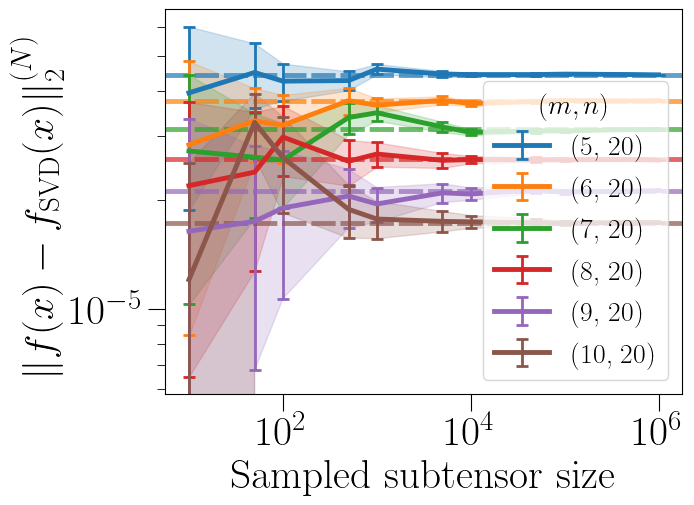

In [10]:
# fmt: off
def plot_error_2(ax):
	for idx, config in enumerate(configurations_norm_2):
		x = num_samples
		y = list_mean_errors_2[idx]
		y_err = list_std_errors_2[idx]
		label = config
		y_norm = list_benchmark_errors_2[idx]
		ax.axhline(y_norm, linestyle=LINESTYLE_2, alpha=0.7, color=colors[idx])
		ax.errorbar(x, y, y_err, linestyle=LINESTYLE_1, label=config, color=colors[idx], elinewidth=2, capsize=4, capthick=2)
		ax.fill_between(x, y - y_err, y + y_err, color=colors[idx], alpha=0.2)
	ax.set_xscale("log")
	ax.set_yscale("log")
	ax.legend(loc="lower right", title=r"$(m, n)$", fontsize=20, title_fontsize=20)

if SHOW_FIGURES:
	fig, ax = create_subplots()
	plot_error_2(ax)
	ax.set_xlabel("Sampled subtensor size")
	ax.set_ylabel(r"$\Vert f(x) - f_{\mathrm{SVD}}(x)\Vert_2^{(N)}$")

### Plot together

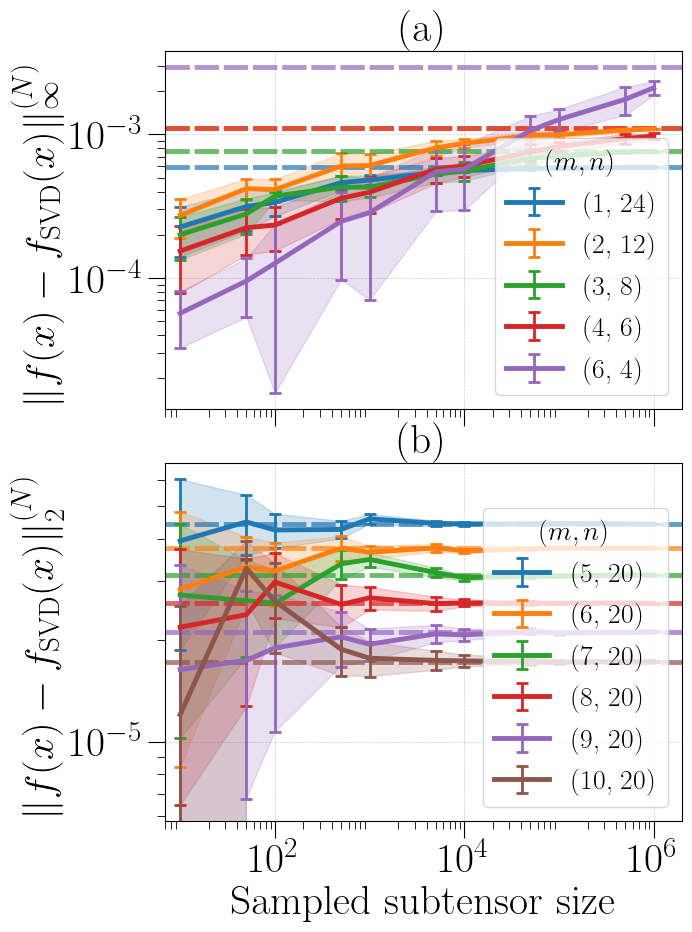

In [11]:
from matplotlib import ticker

fig, axs = create_subplots(2, 1, sharex="col")
plot_error_inf(axs[0])
plot_error_2(axs[1])
fig.subplots_adjust(hspace=0.15)

axs[1].set_xlabel("Sampled subtensor size")
axs[0].set_ylabel(r"$\Vert f(x) - f_{\mathrm{SVD}}(x)\Vert_\infty^{(N)}$")
axs[1].set_ylabel(r"$\Vert f(x) - f_{\mathrm{SVD}}(x)\Vert_2^{(N)}$")

for i, ax in enumerate(axs.flat):
    ax.set_xlim(7)
    ax.set_title(f"(" + chr(ord("a") + i) + ")")
    ax.grid(which="major")
    ax.xaxis.set_minor_locator(ticker.LogLocator(numticks=999, subs="auto"))
    ax.yaxis.set_minor_locator(ticker.LogLocator(numticks=999, subs="auto"))

plt.savefig("figures/sampling.pdf", dpi=300, bbox_inches="tight")